vit에서는 이미지를 패치 단위로 나누어 어텐션 연산을 수행한다.

이러한 패치(텐서)를 나누는 연산을 하기 위해서 pytorch는 `Unfold`라는 연산을 제공한다.

### 샘플 이미지

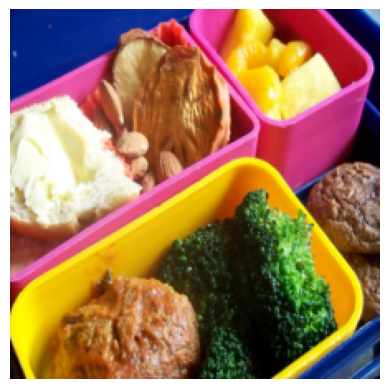

In [3]:
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

transform = transforms.Compose([
transforms.Resize((224, 224)),  
transforms.ToTensor()
])


img_path = './coco_img_sample.jpg'
image = Image.open(img_path).convert('RGB')  
image = transform(image).unsqueeze(0)

image_np = image[0].permute(1, 2, 0).numpy()

plt.imshow(image_np)
plt.axis('off')  
plt.show()

### nn.Unfold

`Unfold`는 `Conv2d`와 유사하게 커널 사이즈, 스트라이드, 패딩 등을 정의 할 수 있다.

컨볼루션 연산의 일환으로 텐서를 펼치는 역할을 하며, 출력 텐서는 기본적으로 연속적(contiguous)이다.

torch.nn.Unfold로 연산되어 나온 텐서는 기존의 텐서와는 다른 메모리 공간을 가지고 연속적이기 때문에 View 연산을 수행할 수 있다.

In [5]:
uf = nn.Unfold(kernel_size=4, stride=4, padding=0)
unfold_image = uf(image)

print(image.shape)
print(unfold_image.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 48, 3136])


`Unfold` 연산을 수행하게 될 경우 모양이 약간 이상함을 확인할 수 있다.

연산후의 텐서 모양은 torch 공식 document에서 확인할 수 있다. 하지만 한번에 이해하기는 어려울 것이다.

쉽게 풀어서 말하면 각 차원이 나타내는 의미로는 0-dim이 배치 단위이다라고 밖에 표현하기 어렵다.

따라서 각 배치가 어떤 값을 담고 있는지를 설명하기 위해 2차원 배열로 설명하자면 다음과 같다.

우선 **열**은 하나의 패치와 같다. 

하나의 패치는 커널크기*이미지 채널이다. 따라서 4*4*3 = 48의 값을 갖음을 확인할 수있다.

이러한 `열 벡터=패치` 들이 하나의 배열을 이루고 있다고 보면 된다.

### 패치 재배치

구현 코드에서는 Unfold로 뽑아낸 텐서를 view와 permute를 통해 재배치한다.

각 연산에 의해 재배치될 때 각 패치의 위치가 어떻게 재배치 될 지는 view연산과 permute연산의 완전한 이해가 필요하다.

In [7]:
v_image = unfold_image.view(1,-1, 224//4, 224//4)
print(v_image.shape)

torch.Size([1, 48, 56, 56])


In [9]:
p_image = v_image.permute(0,2,3,1)
print(p_image.shape)

torch.Size([1, 56, 56, 48])


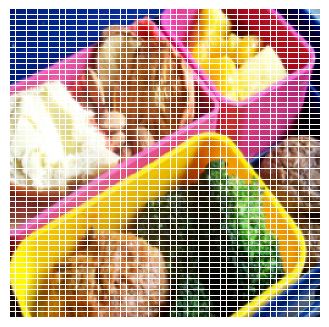

In [11]:
fig, axes = plt.subplots(56, 56, figsize=(4, 4))

for i in range(56):
    for j in range(56):
        patch = p_image[0,i,j,:].view(3,4,4).permute(1,2,0).numpy()
        
        axes[i][j].imshow(patch)
        axes[i][j].axis("off")

plt.show()

위와 같이 패치들이 잘 분리되었고 인덱싱을 통해 이를 사용할 수 있음을 확인할 수 있다.
